In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Reshape, Dropout, Dense 
from tensorflow.keras.layers import Flatten, BatchNormalization
from tensorflow.keras.layers import Activation, ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
import os 
import time
import matplotlib.pyplot as plt

In [ ]:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    tf.test.gpu_device_name()

Mounted at /content/drive
Note: using Google CoLab


''

In [ ]:
# just add flowers somewhere and put the directrory below
# get the path/directory
folder_dir = '/content/drive/My Drive/347Project/Flowers'

# color_mode = "grayscale"
data_set = tf.keras.utils.image_dataset_from_directory(folder_dir, label_mode =None, labels= None, image_size=(64, 64) )

Found 3172 files belonging to 1 classes.


In [ ]:
#scale function
def scale_images(data): 
    image = data
    return image / 255

In [ ]:
ds = data_set
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images) 
# Cache the dataset for that batch 
ds = ds.cache()
# Shuffle it up 
ds = ds.shuffle(60000)
# Batch into 128 images per sample
# ds = ds.batch(32)
# Reduces the likelihood of bottlenecking 
ds = ds.prefetch(16)

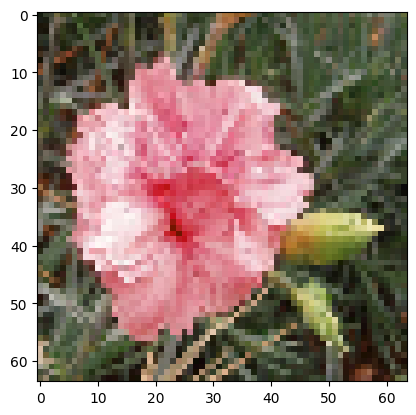

In [ ]:
#this might take a while

plt.imshow(ds.as_numpy_iterator().next()[0])

In [ ]:
def build_generator(): 
    model = Sequential()
    
    # Takes in random values and reshapes it to 7x7x128
    # Beginnings of a generated image
    model.add(Dense(16*16*128, input_dim=128))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((16,16,128)))
    
    # Upsampling block 1 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Upsampling block 2 
    model.add(UpSampling2D())
    model.add(Conv2D(128, 5, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 1
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Convolutional block 2
    model.add(Conv2D(128, 4, padding='same'))
    model.add(LeakyReLU(0.2))
    
    # Conv layer to get to one channel
    model.add(Conv2D(3, 4, padding='same', activation='sigmoid'))
    
    return model

In [ ]:
generator = build_generator()
generator.summary()
img = generator.predict(np.random.randn(4,128,1))

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             4227072   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 up_sampling2d (UpSampling2D  (None, 32, 32, 128)      0         
 )                                                               
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 128)       409728    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                        

In [ ]:
def build_discriminator(): 
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (64,64,3)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model

In [ ]:
discriminator = build_discriminator()
discriminator.summary()
discriminator.predict(img)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 60, 60, 32)        2432      
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 60, 60, 32)        0         
                                                                 
 dropout (Dropout)           (None, 60, 60, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 56, 56, 64)        51264     
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 56, 56, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 64)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 52, 52, 128)      

array([[0.4944654 ],
       [0.49445808],
       [0.49453408],
       [0.49443132]], dtype=float32)

In [ ]:
# Adam is going to be the optimizer for both
from tensorflow.keras.optimizers import Adam
# Binary cross entropy is going to be the loss for both 
from tensorflow.keras.losses import BinaryCrossentropy

g_opt = Adam(learning_rate=0.0001) 
d_opt = Adam(learning_rate=0.00001) 
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [ ]:
class FashionGAN(Model): 
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class 
        super().__init__(*args, **kwargs)
        
        # Create attributes for gen and disc
        self.generator = generator 
        self.discriminator = discriminator
      
    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs): 
        super().compile(*args, **kwargs)
        
        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss 

    def train_step(self, batch):
        # Get the data 
        real_images = batch
        fake_images = self.generator(tf.random.normal((128, 128, 1)), training=False)
        
        # Train the discriminator
        with tf.GradientTape() as d_tape: 
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True) 
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)
            
            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)
            
        # Apply backpropagation - nn learn 
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables) 
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))
        
        # Train the generator 
        with tf.GradientTape() as g_tape: 
            # Generate some new images
            gen_images = self.generator(tf.random.normal((128,128,1)), training=True)
                                        
            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)
                                        
            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels) 
            
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))
        
        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [ ]:
fashgan = FashionGAN(generator, discriminator)
fashgan.compile(g_opt, d_opt, g_loss, d_loss)

import os
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.callbacks import Callback
import h5py

class ModelMonitor(Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.uniform((self.num_img, self.latent_dim,1))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        if epoch % 5 == 0:
            generator.save('/content/drive/My Drive/347Project/SavedFiles/generator.h5')
            discriminator.save('/content/drive/My Drive/347Project/SavedFiles/discriminator.h5') 
        for i in range(self.num_img):
            img = array_to_img(generated_images[i])
            img.save(os.path.join('/content/drive/My Drive/347Project/ImageSpit', f'generated_img_{epoch}_{i}.png'))

In [ ]:
#lmk if call back dosent work.
#you need to create folder for it also

tf.config.run_functions_eagerly(True)
hist = fashgan.fit(ds, epochs=10, callbacks=[ModelMonitor()])

Epoch 1/10
  2/100 [..............................] - ETA: 6:33:15 - d_loss: 0.6129 - g_loss: 0.9352

KeyboardInterrupt: ignored

In [ ]:
imgs = generator.predict(np.random.randn(4,128,1))
# beep beep jeep

In [ ]:
generator.save('generator.h5')
discriminator.save('discriminator.h5')

In [ ]:
generator.load_weights("generator.h5")